<p style="font-size:26px;text-align:center"> <b>EYE PROBLEMS - BLINDNESS DETECTION - FINAL MODEL</b> </p>

Source : https://www.kaggle.com/c/aptos2019-blindness-detection

Data : 

As we have Diabetic Retinopathy grades available only for train fundus images (3662), we used other sources to have some more fundus images for training.

*   2019 APTOS Fundus images - https://www.kaggle.com/c/aptos2019-blindness-detection
*   IDRiD Fundus images  - https://ieee-dataport.org/open-access/indian-diabetic-retinopathy-image-dataset-idrid 
*   MESSIDOR Fundus images - https://www.adcis.net/en/third-party/messidor/ 


Download train & test fundus images, and their respective DR grades csv file

**Problem statement:**

As of now, they rely on highly trained doctors to review the images of the retina and provide diagnosis. So, our goal is to scale their efforts through technology; by building a robust ML/DL trained models, to identify potential patients for diabetic retinopathy.


In [1]:
#Importing packages
import tensorflow as tf
import os
import cv2
import imageio
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.patches as mpatches
from scipy.signal import find_peaks
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import joblib
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten
from tensorflow.keras.models import Model
import random as rn
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
import datetime
import glob
import warnings
from tensorflow.keras import models, layers
from sklearn.metrics import cohen_kappa_score
import math
from keras.regularizers import l1 ,l2
import keras
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from matplotlib import pyplot as plt

import argparse
import os
import warnings

from keras.callbacks import Callback
from keras import backend as K
import logging
warnings.filterwarnings('ignore')


## Function 1:: Final(X) - returns the prediction of (a single data points i.e 1*d feature)

In [2]:
def final_predict(img_path):
    img = cv2.imread(img_path) # Reading image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting color space to RGB
    
    # Step1 - Seperation of green channel of images
    red, green, blue = cv2.split(img) 
    
    # Step2 - Contrast enhancement by applying CLAHE technique to improve the contrast of images - 
    # the concept acquired from https://stackoverflow.com/questions/38504864/opencv-clahe-parameters-explanation
    cla = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)) 
    e_img = cla.apply(green)

    # Step3 - Draw a circle around image centre 
    height, width = e_img.shape    
    x = int(width/2)  # X co-ordinate
    y = int(height/2) # Y co-ordinate
    r = np.amin((x,y)) # radius of the circle
    circle_img = np.zeros((height, width), np.uint8) 
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1) # method to draw a circle on image 
    c_img = cv2.bitwise_and(e_img, e_img, mask=circle_img)  # fitting the circle on image using a bitwise_and 

    # Step4 - Resizing the image into 512 * 512 
    rimg = cv2.resize(c_img, (512, 512)) # resizing the image 

    # Step5 - Cropping Uninformative area around the circle
    mask = rimg > 7 # Set True if the pixel value greater than the tolerance value which is 7, Tolerance define "how much black" we can tolerate. If we set this number too high, it will correspond to bright pixel (0=black, 255=white), so it will not crop anything  
    # Construct an open mesh from multiple sequence - reference https://stackoverflow.com/questions/62505046/what-does-numpy-ix-function-do-and-what-is-the-output-used-for
    rimg =  rimg[np.ix_(mask.any(1),mask.any(0))] 

    # Step6 - Image smoothing
    fin_img=cv2.addWeighted(rimg,4, cv2.GaussianBlur( rimg , (0,0) , 10) ,-4 ,128) 
    
    print("Image Preprocessing is completed ...")
    
    fin_img = cv2.cvtColor(fin_img, cv2.COLOR_BGR2RGB)
    
    fin_img_resized = cv2.resize(fin_img, (320, 320)) # resizing the image 
    fin_img_resized = tf.expand_dims(fin_img_resized, axis=0)

    # Loading the pre-trained VGG model
    model = load_model('C:/Users/Muru/Downloads/weights-vgg.hdf5')
    print("Model load is done")
    
    logging.disable(logging.WARNING)

    y_pred = model.predict(fin_img_resized)
    y_pred_class = np.argmax(y_pred, axis=1)
    print("Prediction is completed Successfully!!!.....")
    
    print("DR grade of the below image is {}".format(y_pred_class))

    plt.title("Original Image")
    plt.imshow(img)

Image Preprocessing is completed ...
Model load is done
Prediction is completed Successfully!!!.....
DR grade of the below image is [4]


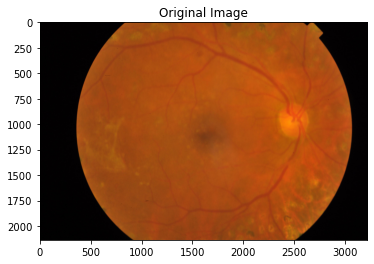

In [81]:
final_predict('C:/Users/Muru/Downloads/train_images/001639a390f0.png')

Image Preprocessing is completed ...
Model load is done
Prediction is completed Successfully!!!.....
DR grade of the below image is [0]


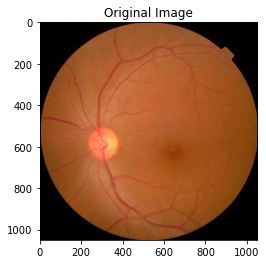

In [82]:
final_predict('C:/Users/Muru/Downloads/train_images/002c21358ce6.png')

## Function 2:: final(X, Y) - Fitting trained model on Set of test data with Actual Y & compute the error metric

In [14]:
img_path = list()
img_fullname = list()
img_name = list()
for dirname, _, filenames in os.walk('C:/Users/Muru/Downloads/train_images/'):
    for filename in filenames:
        img_path.append(os.path.join(dirname, filename))
        temp = os.path.join(dirname, filename)
        temp = temp.split("/")[-1]
        img_fullname.append(temp)
        temp = temp.split(".")[0]
        img_name.append(str(temp))

In [4]:
pre_df = pd.DataFrame()
pre_df['path'] = img_path
pre_df['fullname'] = img_fullname
pre_df['id_code'] = img_name

In [5]:
# Reading DR grades files of 2019
train2019 = pd.read_csv('C:/Users/Muru/Downloads/train.csv')
train2019 = train2019[['id_code', 'diagnosis']]

In [6]:
# Merging the image path & DR grades 
pre_df = pd.merge(pre_df, train2019, on='id_code', how='left')

In [7]:
pre_df = pre_df[pre_df['diagnosis'].notna()] # removing row if the DR grade is NaN

In [8]:
print(pre_df[pre_df['diagnosis'].isnull()]) # Verify if there is any NaN present in the DR grades field

Empty DataFrame
Columns: [path, fullname, id_code, diagnosis]
Index: []


In [9]:
convert_dict = {'diagnosis': str}
pre_df = pre_df.astype(convert_dict)

In [10]:
# train test split
from sklearn.model_selection import train_test_split
y = pre_df['diagnosis'].values
X_train, X_test, y_train, y_test = train_test_split(pre_df, y, test_size=0.20, stratify=y)

In [11]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2929, 4)
(733, 4)
(2929,)
(733,)


In [17]:
# This concept acquired from https://biomedpharmajournal.org/vol10no2/diabetic-retinal-fundus-images-preprocessing-and-feature-extraction-for-early-detection-of-diabetic-retinopathy/
# Code reference for cropping and image smoothing - https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy

def preprocess_img(img_df, dir_path):
    os.makedirs(dir_path)
    for i in tqdm(range(len(img_df['path'].values))):
        
        img = cv2.imread(img_df['path'].values[i]) # Reading image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting color space to RGB

        # Step1 - Seperation of green channel of images
        red, green, blue = cv2.split(img) 

        # Step2 - Contrast enhancement by applying CLAHE technique to improve the contrast of images - 
        # the concept acquired from https://stackoverflow.com/questions/38504864/opencv-clahe-parameters-explanation  
        cla = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)) 
        e_img = cla.apply(green)

        # Step3 - Draw a circle around image centre 
        height, width = e_img.shape    
        x = int(width/2)  # X co-ordinate
        y = int(height/2) # Y co-ordinate
        r = np.amin((x,y)) # radius of the circle
        circle_img = np.zeros((height, width), np.uint8) 
        cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1) # method to draw a circle on image 
        c_img = cv2.bitwise_and(e_img, e_img, mask=circle_img)  # fitting the circle on image using a bitwise_and 

        # Step4 - Resizing the image into 512 * 512 
        rimg = cv2.resize(c_img, (512, 512)) # resizing the image 

        # Step5 - Cropping Uninformative area around the circle
        mask = rimg > 7 # Set True if the pixel value greater than the tolerance value which is 7
        rimg =  rimg[np.ix_(mask.any(1),mask.any(0))] # Construct an open mesh from multiple sequence - reference https://stackoverflow.com/questions/62505046/what-does-numpy-ix-function-do-and-what-is-the-output-used-for

        # Step6 - Image smoothing
        # addWeighted - it helps in adding two images and also blending those by passing the alpha (4), beta (-4) and gamma (128) values - alpha * image1 + beta * image2 + gamma
        # GaussianBlur - It used Gaussian filte is a low-pass filter that removed the high frequency components are reduced
        fin_img=cv2.addWeighted(rimg,4, cv2.GaussianBlur( rimg , (0,0) , 10) ,-4 ,128) 

        img_path = os.path.join(dir_path + '/','{}.png'.format(img_df['id_code'].values[i]))
        cv2.imwrite(img_path, fin_img)


In [30]:
def model_performance(X, Y, dir_path):
    
    preprocess_img(X, dir_path) #Image preprocessing
    print("Image preprocessing is done...")
    # to fetch the image path and name of the preprocessed images
    img_path = list()
    img_fullname = list()
    img_name = list()
    for dirname, _, filenames in os.walk(dir_path + '/'):
        for filename in filenames:
            img_path.append(os.path.join(dirname, filename))
            temp = os.path.join(dirname, filename)
            temp = temp.split("/")[-1]
            img_fullname.append(temp)
            temp = temp.split(".")[0]
            img_name.append(str(temp))
            
    pre_df = pd.DataFrame()
    pre_df['path'] = img_path
    pre_df['fullname'] = img_fullname
    pre_df['id_code'] = img_name
    
    # Reading DR grades files of 2019
    train2019 = pd.read_csv('C:/Users/Muru/Downloads/train.csv')
    train2019 = train2019[['id_code', 'diagnosis']]
    
    # Merging the image path & DR grades 
    pre_df = pd.merge(pre_df, train2019, on='id_code', how='left')
    
    pre_df = pre_df[pre_df['diagnosis'].notna()] # removing row if the DR grade is NaN
    
    convert_dict = {'diagnosis': str}
    pre_df = pre_df.astype(convert_dict)
    
    test_datagen=ImageDataGenerator(rescale=1./255.)

    test_pred_2019=test_datagen.flow_from_dataframe(dataframe=pre_df, directory=None, x_col="path", 
                batch_size=1, shuffle=False, class_mode=None, target_size=(320,320))
    
    # Loading the pre-trained VGG model
    model = load_model('C:/Users/Muru/Downloads/weights-vgg.hdf5')
    print("Model load is done...")
    
    logging.disable(logging.WARNING)
    
    y_pred = model.predict(test_pred_2019)
    y_pred_class = np.argmax(y_pred, axis=1)
    
    print("Model Prediction is done...")
    
    pred = pd.DataFrame() # storing predicted DR grades into the dataframe 
    pred['Id_code'] = pre_df['id_code']
    pred['Predicted_DR'] = y_pred_class
    pred['Actual_DR'] = pre_df['diagnosis']
    
    print(" ")
    cohen = cohen_kappa_score(y_pred_class, pre_df['diagnosis'].astype('int'), weights='quadratic')
    print("Quadratic Cohen kappa score of VGG model on test data is - %.3f" %cohen)
    
    print(" ")
    print ('Classification Report : \n', classification_report(pre_df['diagnosis'].astype('int'), y_pred_class))
    sns.heatmap(confusion_matrix(pre_df['diagnosis'].astype('int'), y_pred_class), annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')
    plt.show()
    
    return pred

100%|████████████████████████████████████████████████████████████████████████████████| 733/733 [01:16<00:00,  9.64it/s]


Image preprocessing is done...
Found 733 validated image filenames.
Model load is done...
Model Prediction is done...
 
Quadratic Cohen kappa score of VGG model on test data is - 0.829
 
Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       361
           1       0.56      0.47      0.51        74
           2       0.67      0.82      0.74       200
           3       0.50      0.28      0.36        39
           4       0.83      0.25      0.39        59

    accuracy                           0.79       733
   macro avg       0.70      0.56      0.59       733
weighted avg       0.79      0.79      0.77       733



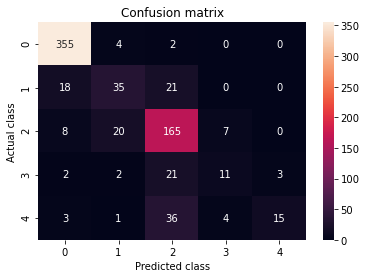

In [31]:
dir_path = 'C:/Users/Muru/Downloads/preprocessed_fundus'
test_prediction = model_performance(X_test, y_test, dir_path)

In [36]:
test_prediction[:30]

,Id_code,Predicted_DR,Actual_DR
0,0024cdab0c1e,1,1
1,005b95c28852,0,0
2,012a242ac6ff,2,2
3,014508ccb9cb,0,0
4,0161338f53cc,2,2
5,0212dd31f623,0,0
6,03a7f4a5786f,0,4
7,03fd50da928d,2,2
8,0415fc68b176,2,2
9,04efb1a284cc,0,0


## Conclusion -

* Its been deployed successfully in the local machine. 

* Here is the link of our deployed model - https://drive.google.com/file/d/1nhLNkTZ3DhUP62HHYuBGpyQSZ3l6fqUe/view?usp=sharing

* Achieved Accuracy ~80%  & Quadratic Cohen kappa score - 0.82 with VGG16 model using Transfer learning